In [1]:
# !pip install ultralytics

In [2]:
# !pip install networkx

In [1]:
import numpy as np
import os
import cv2 as cv
from ultralytics import YOLO
import torch
import pandas as pd
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt

## Loading the pretraining model

In [2]:
cwd = os.getcwd()
cwd

'd:\\Graduation work\\project'

In [3]:
# model = YOLO("yolov8m.pt")
model = YOLO(cwd + "/best (1).pt")

In [4]:
# model.train(data="/content/drive/MyDrive/pr2/data.yaml", epochs=100)

### Recognition of components and nets from pic

In [5]:
image_path = cwd + '/imgs/5.2.png'
# possible variants of image:
# 1.jpg
# 2.png
# 3.jpeg
# 4.png
# 5.png
# 5.1.png
# 5.2.png
# 6.png

In [6]:
results = model.predict(image_path)
result = results[0]


image 1/1 d:\Graduation work\project\imgs\5.2.png: 352x640 8 nets, 2 net_nodes, 3 ress, 2 sources, 299.1ms
Speed: 0.4ms preprocess, 299.1ms inference, 9.5ms postprocess per image at shape (1, 3, 352, 640)


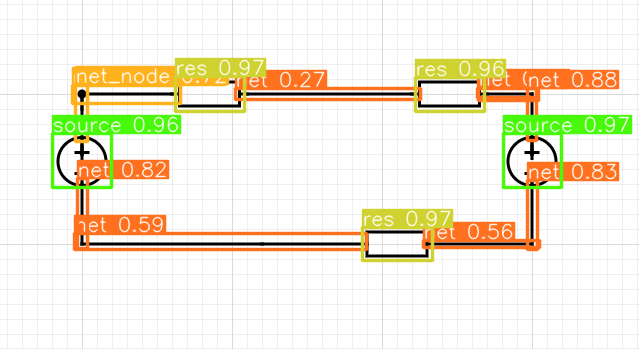

In [8]:
from PIL import Image
Image.fromarray(result.plot()[:,:,::-1])

### Preprocessing obtained results

In [9]:
# Printing names of recognized components

# for r in result:
#   for c in r.boxes.cls:
#     match c:
#       case 0: print('Capacitor')
#       case 1: print('Inductor')
#       case 2: print('Net')
#       case 3: print('Net_node')
#       case 4: print('Resistor')
#       case 5: print('Source')

In [10]:
# Assign values to obtained bounding boxes: name_of_component + index_of_component
components_dict = {
    'index': [],
    'name': []
}
components = ['cap', 'ind', 'net', 'net_node', 'res', 'src']
# data = []
for i, c in enumerate(result.boxes.cls.cpu().numpy()):
  # data.append((components[c.astype(np.int32)], i))
  components_dict['index'].append(i)
  components_dict['name'].append(components[c.astype(np.int32)])
# data = np.array(data)
components_dict['name'] = np.array(components_dict['name'])
components_dict['index'] = np.array(components_dict['index'])

In [11]:
# Names of recognized components
components_dict['name']

array(['src', 'res', 'res', 'res', 'src', 'net', 'net', 'net', 'net_node', 'net_node', 'net', 'net', 'net', 'net', 'net'], dtype='<U8')

In [12]:
# Indices of components
all_indices = components_dict['index'].astype(np.int32)
print(f'All component indices:\n{all_indices}')

All component indices:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [13]:
# Indices of nets
net_indices = components_dict['index'][np.where(components_dict['name'] == 'net')].astype(np.int32)
netnode_indices = components_dict['index'][np.where(components_dict['name'] == 'net_node')].astype(np.int32)
nets_indices = np.concatenate((net_indices, netnode_indices),axis=0)
componets_indices = np.setdiff1d(all_indices, nets_indices)
src_indices = components_dict['index'][np.where(components_dict['name'] == 'src')].astype(np.int32)
print(f'Net indices:\n{net_indices}')
print(f'Net + node indices:\n{netnode_indices}')
print(f'All indices related to nets:\n{nets_indices}')
print(f'All indices related to components:\n{componets_indices}')
print(f'Indices related to sources:\n{src_indices}')

Net indices:
[ 5  6  7 10 11 12 13 14]
Net + node indices:
[8 9]
All indices related to nets:
[ 5  6  7 10 11 12 13 14  8  9]
All indices related to components:
[0 1 2 3 4]
Indices related to sources:
[0 4]


In [14]:
def sort_indices(indices):
  '''
  Function for sorting indices

  :param indices: indices to sort
  :return: sorted indices
  '''

  for i in range(len(indices)):
    for j in range(len(indices)):
      if (result.boxes.xyxy[indices[i]].cpu().numpy().astype(np.int32)[0] >= result.boxes.xyxy[indices[j]].cpu().numpy().astype(np.int32)[0]):
        indices[i], indices[j] = indices[j], indices[i]
  return indices[::-1]

### Function for vsualize bounding boxes

In [15]:
def visualize_boxes(path_to_img, indices):
  '''
  Function for visualizing bounding boxes

  :param path_to_img: path to image
  :param indices: indices of boxes to visualize
  '''

  img = cv.imread(path_to_img)
  for ind in indices:
    x1, y1, x2, y2 = result.boxes.xyxy.cpu().numpy().astype(np.int32)[ind]
    top_left = (x1,y1)
    bottom_right = (x2,y2)
    color = (0, 255, 0)
    cv.rectangle(img, pt1=top_left, pt2=bottom_right, color=color)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

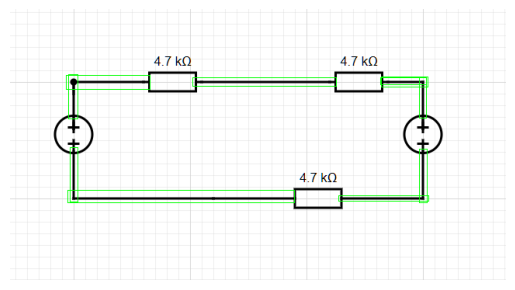

In [16]:
visualize_boxes(image_path, nets_indices)

## Building graph from obtained bounding boxes

### Functions for building a graph

In [17]:
def rectangles_intersect(rect1_indx, rect2_indx):
  '''
  Function for checking the intersection two bounding boxes

  :param rect1_indx: index of first bounding box
  :param rect2_indx: index of second bounding box
  :return: True if rectangles intersect else False
  '''

  x1_rect1, y1_rect1, x2_rect1, y2_rect1 = result.boxes.xyxy[rect1_indx].cpu().numpy().astype(np.int32)
  x1_rect2, y1_rect2, x2_rect2, y2_rect2 = result.boxes.xyxy[rect2_indx].cpu().numpy().astype(np.int32)

  x_intersect = max(x1_rect1, x1_rect2) <= min(x2_rect1, x2_rect2)
  y_intersect = max(y1_rect1, y1_rect2) <= min(y2_rect1, y2_rect2)

  return x_intersect and y_intersect

In [18]:
def laplacian_matrix(indices):
  '''
  Function for obtainig matrices which describe graph - degree matrix, adjencency matrix, laplacian matrix

  :param indices: all indices required for building a graph
  :return: laplacian_matrix, degree_matrix, adjacency_matrix
  '''
  inds = indices.copy()
  adjacency_matrix = np.zeros((len(inds), len(inds)))
  degree_matrix = np.zeros((len(inds), len(inds)))
  laplacian_matrix = np.zeros((len(inds), len(inds)))
  counter = 0
  for i in inds:
    for j in inds:
      if (rectangles_intersect(i, j)):
        if i != j:
          adjacency_matrix[i][j] = 1
          counter += 1
    degree_matrix[i][i] = counter
    counter = 0
  laplacian_matrix = degree_matrix - adjacency_matrix

  return laplacian_matrix, degree_matrix, adjacency_matrix

In [19]:
lap_mx, dg_mx, adj_mx = laplacian_matrix(all_indices)

### Library [**NetworkX**](https://networkx.org/documentation/stable/index.html) will be used for working with graphs. Obtained above matrices can't be used for analyzing electric circuit - it's needed to transform graph (eliminate or merge in groups bounding boxes related to nets).

In [20]:
# Making graph from Adjacency matrix
g = nx.from_numpy_array(adj_mx)

In [21]:
# Checking has graph got subgraphs inside or not

subgraphs = [g.subgraph(c).copy() for c in nx.connected_components(g)]
number_of_subgraphs = len(subgraphs)
print(f'{number_of_subgraphs} subgraphs in initial graph')
if number_of_subgraphs > 1:
  for i, g in enumerate(subgraphs,start=1):
    print(f"Subgraph {i}: Nodes: {g.nodes()} Edges: {g.edges()}")

1 subgraphs in initial graph


### Removing nodes related to components and defining the subgraphs related to nets

In [22]:
#Making graphs without sources

adj_list = {}
adj_lists = []
Sources = []
edges = []
Graphs = []
edge_labels = {}

for subgraph in subgraphs:
  # removing nodes related to components
  mask = np.in1d(subgraph.nodes(), np.setdiff1d(componets_indices, src_indices))
  mask_src = np.in1d(subgraph.nodes(), src_indices)
  nodes_of_comp = np.array(subgraph.nodes())[mask]
  nodes_of_src = np.array(subgraph.nodes())[mask_src]
  sub_without_components = subgraph.copy()
  sub_without_components.remove_nodes_from(nodes_of_comp)

  #
  nets = [sub_without_components.subgraph(c).copy() for c in nx.connected_components(sub_without_components)]
  for comp in np.concatenate((nodes_of_comp, nodes_of_src)):
    neig = np.array(list(subgraph.neighbors(comp)))
    for i, sub in enumerate(nets):
      if True in np.in1d(neig, sub.nodes()):
        edges.append(i)

    if (len(edges) != 1): 
      if components_dict['name'][comp] == 'cap':
        # edges.append({"weight": -1j*1e6})
        edges.append({"weight": 1})
        edge_labels[(edges[0],edges[1])] = 'cap'
      elif components_dict['name'][comp] == 'res':
        edges.append({"weight": 2})
        # edges.append({"weight": 1e-3})
        edge_labels[(edges[0],edges[1])] = 'res'
      elif components_dict['name'][comp] == 'ind':
        # edges.append({"weight": 1j*1e3})
        edges.append({"weight": 3})
        edge_labels[(edges[0],edges[1])] = 'ind'


    adj_list[comp] = list(edges)
    edges.clear()
  nodes = np.arange(len(nets))

  # array of sources
  sources = np.zeros(len(nets))

  # building new graphs
  G = nx.MultiGraph()
  G.add_nodes_from(nodes)
  G.add_edges_from([value for value in adj_list.values() if len(value) == 3])

  sources[[value for value in adj_list.values() if len(value) == 1]] = 1
  Sources.append(sources)

  Graphs.append(G)
  adj_lists.append(adj_list.copy())

  # cleaning variables
  adj_list.clear()
  edges.clear()

In [23]:
print(adj_lists)

[{1: [1, 2, {'weight': 2}], 2: [0, 1, {'weight': 2}], 3: [0, 2, {'weight': 2}], 0: [0], 4: [1]}]


In [250]:
# Making graphs with sources

# adj_list = {}
# adj_lists = []
# edges = []
# Graphs = []
# edge_labels = {}


# for subgraph in subgraphs:
#   # removing nodes related to components
#   mask = np.in1d(subgraph.nodes(), componets_indices)
#   nodes_of_comp = np.array(subgraph.nodes())[mask]
#   sub_without_components = subgraph.copy()
#   sub_without_components.remove_nodes_from(nodes_of_comp)

#   #
#   nets = [sub_without_components.subgraph(c).copy() for c in nx.connected_components(sub_without_components)]
#   for comp in nodes_of_comp:
#     neig = np.array(list(subgraph.neighbors(comp)))
#     for i, sub in enumerate(nets):
#       if True in np.in1d(neig, sub.nodes()):
#         # if True in np.in1d(comp, srcs): print('true', comp, i)
#         edges.append(i)

#     if (len(edges) != 1): 
#       if components_dict['name'][comp] == 'cap':
#         # edges.append({"weight": -1j*1e6})
#         edges.append({"weight": 1})
#         edge_labels[(edges[0],edges[1])] = 'cap'
#       elif components_dict['name'][comp] == 'res':
#         edges.append({"weight": 2})
#         # edges.append({"weight": 1e-3})
#         edge_labels[(edges[0],edges[1])] = 'res'
#       elif components_dict['name'][comp] == 'ind':
#         # edges.append({"weight": 1j*1e3})
#         edges.append({"weight": 3})
#         edge_labels[(edges[0],edges[1])] = 'ind'
#       elif components_dict['name'][comp] == 'src':
#         # edges.append({"weight": 1j*1e3})
#         edges.append({"weight": 4})
#         edge_labels[(edges[0],edges[1])] = 'src'

        
#     adj_list[comp] = list(edges)
#     edges.clear()
#   nodes = np.arange(len(nets))

#   # building new graphs
#   G = nx.MultiGraph()
#   G.add_nodes_from(nodes)
#   G.add_edges_from(adj_list.values())

#   # assigning weights to edges
#   # for u, v, data in G.edges(data=True):
#   #   G[u][v][0]['weight'] = 101

#   Graphs.append(G)
#   # print(adj_list)
#   adj_lists.append(adj_list.copy())

#   # cleaning variables
#   adj_list.clear()
#   edges.clear()

In [251]:
# Removing edges in graph by weight name

# sources_list = list(filter((lambda e: e[2] == 4), (e for e in Graphs[0].edges(data='weight'))))
# print(sources_list)
# sources_ids = list(e[:2] for e in sources_list)
# print(sources_ids)
# Graphs[0].remove_edges_from(sources_ids)
# print(Graphs[0].nodes(), Graphs[0].edges(data=True))

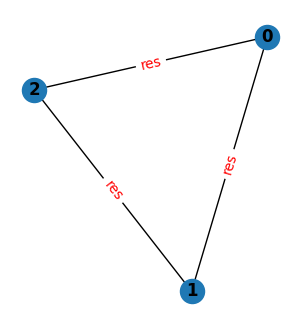

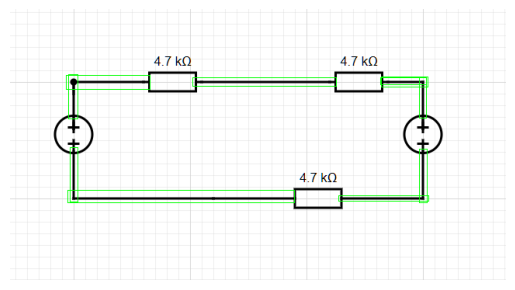

In [26]:
# Visualizing graph and initial circuit

plt.figure(figsize=(8, 4))
pos = nx.spring_layout(G, seed=0xC0FFEE)
for i, g in enumerate(Graphs, start=1):
  plt.subplot(1,2, i)
  nx.draw(g, with_labels=True, font_weight='bold', pos=pos, labels={node: node for node in G.nodes()}, )
  nx.draw_networkx_edge_labels(
    g, pos,
    edge_labels=edge_labels,
    font_color='red',
)
plt.show()
visualize_boxes(image_path, nets_indices)

In [281]:
# Visualizing graphs using Matplotlib. It's needed for parallel edges catching

# pos = nx.random_layout(Graphs[0], seed=0xC0FFEE)
# nx.draw_networkx_nodes(Graphs[0], pos, node_color = 'r', node_size = 100, alpha = 1)
# ax = plt.gca()
# for e in Graphs[0].edges:
#     ax.annotate("",
#                 xy=pos[e[0]], xycoords='data',
#                 xytext=pos[e[1]], textcoords='data',
#                 arrowprops=dict(arrowstyle="->", color="0.5",
#                                 shrinkA=5, shrinkB=5,
#                                 patchA=None, patchB=None,
#                                 connectionstyle="arc3,rad=rrr".replace('rrr',str(0.3*e[2])
#                                 ),
#                                 ),
#                 )
# plt.axis('off')
# plt.show()

In [30]:
# Making adjacency matrix from graph

adj_np = nx.to_numpy_array(Graphs[0])
print(adj_np)

[[          0           2           2]
 [          2           0           2]
 [          2           2           0]]


In [31]:
# Making Admittance matrix from Adjacency matrix

V0 = 230
f = 50
theta = 0
omega = 2*np.pi*f
R = 1
C = 1/(1j*10e-3*omega)
L = 1j*1e-3*omega

Y = np.zeros(adj_np.shape, dtype=np.csingle)
for i in range(adj_np.shape[0]):
    for j in range(adj_np.shape[1]):
        if adj_np[i][j] == 1:
            Y[i][j] = 1/C           #capacitance
        if adj_np[i][j] == 2:
            Y[i][j] = 1/R           #resistance
        if adj_np[i][j] == 3:
            Y[i][j] = 1/L           #inductance
Y = -Y
for i in range(adj_np.shape[0]):
    Y[i][i] = -Y[i].sum()
B = np.imag(Y)
G = np.real(Y)

In [32]:
print(f'Y:\n{Y}\n\nB:\n{B}\n\nG:\n{G}\nNum of busses: {Y.shape[0]}')

Y:
[[ 2.-0.j -1.-0.j -1.-0.j]
 [-1.-0.j  2.-0.j -1.-0.j]
 [-1.-0.j -1.-0.j  2.-0.j]]

B:
[[         -0          -0          -0]
 [         -0          -0          -0]
 [         -0          -0          -0]]

G:
[[          2          -1          -1]
 [         -1           2          -1]
 [         -1          -1           2]]
Num of busses: 3


In [33]:
import numpy as np
from numpy import linalg as la
from scipy import optimize as opt

In [35]:
def power_flow(v,theta,g,b,i,j):
    '''
    Function for calculating active and reactive power at the bus

    :param v: vector of bus voltages 
    :param theta: vector of bus phase differences
    :param g: real part of admittance matrix
    :param b: imaginary part of admittance matrix
    :param i: index of first bus
    :param j: index of second bus
    :return: P (active power), Q (reactive power)
    '''

    P = v[i]*v[j]*(g[i][j]*np.cos(theta[i]-theta[j]) +b[i][j]*np.sin(theta[i]-theta[j])) - g[i][j]*v[i]**2
    Q = v[i]*v[j]*(-b[i][j]*np.cos(theta[i]-theta[j]) +g[i][j]*np.sin(theta[i]-theta[j])) + b[i][j]*v[i]**2
    
    return P,Q

In [36]:
def bus_powers(v,theta, g,b,p0,q0):
    '''
    Function for calculating power between buses

    :param v: vector of bus voltages 
    :param theta: vector of bus phase differences
    :param g: real part of admittance matrix
    :param b: imaginary part of admittance matrix
    :param p0: vector of active power consumption 
    :param q0: vector of reactive power consumption
    :return: np.array of unknown powers (np.array(P,Q))
    '''

    num_of_buses = g.shape[0]
    P = np.zeros(num_of_buses)
    Q = np.zeros(num_of_buses)

    for i in range(num_of_buses):
        for j in range(num_of_buses):
            pf,qf = power_flow(v,theta,g,b,i,j)
            P[i] = P[i] + pf
            Q[i] = Q[i] + qf

        P[i] = P[i] + p0[i]
        Q[i] = Q[i] + q0[i]
    return np.concatenate((np.array(P)[np.where(Sources == 0)[0]], np.array(Q)[np.where(Sources == 0)[0]]), axis=0)

In [37]:
# Grounds = np.array([0,1,0])
Grounds = None
Sources = Sources[0]
num_of_slack = np.atleast_1d(Grounds == 1).nonzero()[0].shape[0] + np.atleast_1d(Sources == 1).nonzero()[0].shape[0]
print(num_of_slack)

2


In [38]:
# Defining component's classes

# class Resistor:
#     def __init__(self, node1, node2, value):
#         self.node1 = node1
#         self.node2 = node2
#         self.value = value
# class Capacitor:
#     def __init__(self, node1, node2, value):
#         self.node1 = node1
#         self.node2 = node2
#         self.value = value
# class Inductor:
#     def __init__(self, node1, node2, value):
#         self.node1 = node1
#         self.node2 = node2
#         self.value = value
# class Passive_comp:
#     def __init__(self, node1, node2, value):
#         self.node1 = node1
#         self.node2 = node2
#         self.value = value
class Source:
    def __init__(self, node, voltage, theta):
        self.node = node
        self.voltage = voltage
        self.theta = theta

In [43]:
# Making list with source classes
srcs = []
for ind in np.where(Sources == 1)[0]:
    srcs.append(Source(ind, V0, theta))
srcs[1].voltage = 0         # set voltage of second source to zero

In [44]:
def solve_pf(g, b, p0, q0, initial_guess):
    '''
    Function for solving power flow equations

    :param g: real part of admittance matrix
    :param b: imaginary part of admittance matrix
    :param p0: vector of active power consumption 
    :param q0: vector of reactive power consumption
    :param initial_guess: starting point in Newton-Rapson
    :return: np.array of unknown voltages and thetas (np.array(V, theta))
    '''
    num_of_buses = g.shape[0]
    slack_bus_indices = np.where(np.concatenate((Sources, Sources),axis=0) == 1)
    non_slack_buses = np.setdiff1d(np.arange(num_of_buses), slack_bus_indices)

    # initial_guess = np.concatenate((np.full(num_of_buses - num_of_slack, V0), (np.full(num_of_buses - num_of_slack, theta))))
    
    def equations(x):
        for i, ind in enumerate([0,1,3,4]):
            if (ind < x.shape[0]):
                if (ind < x.shape[0]/2):
                    x = np.insert(x,ind,srcs[i].voltage)
                else:
                    x = np.insert(x,ind,srcs[i-int(x.shape[0]/2)].theta)
            else:
                x = np.append(x,srcs[i-int(x.shape[0]/2)].theta)
        v_arr = x[:x.shape[0]//2]
        theta_arr = x[x.shape[0]//2:]

        return bus_powers(v_arr,\
                           theta_arr, g,b,\
                            p0, q0)
        
    return opt.fsolve(equations, initial_guess)

In [45]:
num_of_buses = Y.shape[0]
initial_guess = np.concatenate((np.full(num_of_buses - num_of_slack, V0), (np.full(num_of_buses - num_of_slack, theta))))
x = solve_pf(G,B, np.array([0,0,0]), np.array([0,0,0]),initial_guess)
x

array([        115,           0])

In [46]:
# def solve_pf(g,b):
#     # x[0] = v[1]
#     # x[1] = theta[1]
#     # x[2] = v[2]
#     # x[3] = theta[2]
#     return opt.fsolve(lambda x:bus_powers(np.array([V0, 0, x[0]]),\
#                                           np.array([0, 0, x[1]]), g,b, \
#                                           np.array([0, 0, 0]), np.array([0, 0, 0])), np.array([V0, 0, 0, 0]))

In [47]:
# x = solve_pf(G,B)
# x